# Title of Project: Real estate Affordability and Venue Analysis of London

## A- Inroduction
### A.1- Problem Statement

London is considered to be one of the most important global cities  around the world and has been called the most powerful, most desirable, most influential, most visited, most expensive, innovative, sustainable, most investment-friendly, and most-popular-for-work city. London exerts a considerable impact upon the arts, commerce, education, entertainment, fashion, finance, healthcare, media, professional services, research and development, tourism and transportation.
As mentioned earlier, London is one of the most worldwide expensive cities, the type of business they want to install is less intense. Considering the city residents, it is desirable to choose the regions where real estate are more affordable. At the same time, they may want to select the area according to the social places density. However, it is difficult to obtain information that will guide investors in this direction, nowadays.
Considering all mentioned issues, the problem can be analyzed by creating a map of London and inserting the information on that, and finally clustering each area based on the density of venue. 


### A.2- Data Description

Ratio of House Prices to Earnings (full-time workers by place of work) of London area published by UK Office of National Statistics is used. This dataset shows the average house price/earnings ratio, which is an important indicator of housing affordability. Ratios are calculated by dividing house price by the median earnings of a borough. The Annual Survey of Hours and Earnings (ASHE) is based on a 1 per cent sample of employee jobs. Information on earnings and hours is obtained in confidence from employers. It does not cover the self-employed nor does it cover employees not paid during the reference period. The statistics used are workplace based full-time individual earnings. For this work, I use the data related to 2016. 

1- In order to calculate the latitude and longitude of different borough, I used geopy.

2- I used Forsquare API to get the most common venues of given Borough of London.

3- I used the Search Nearby service from Google Maps to employ the center coordinates of the each Borough

## B. Methodolgy

### B.1- Craeting Dataframe and data pre-processing


In this work, GitHub repository is used as the database. The data includes the Borough (Name), Ratio, Latitude and Longitude information of the London area.

In [1]:
#Improting libraries
import pandas as pd 
import numpy as np
import requests

In [2]:
url='https://github.com/Elnazlmch/github-example/blob/master/uk_data.csv'

df_uk = pd.read_html (url, header=0, flavor='html5lib')[0]
df_uk.drop(['Unnamed: 0'], axis=1, inplace=True)
print(" Head list of Real Estate Affordability:")
df_uk.head()

 Head list of Real Estate Affordability:


,Name,Ratio,Latitude,Longitude
0,City of London,17.51,51.507322,-0.127647
1,Barking and Dagenham,10.55,51.554117,0.150504
2,Barnet,15.19,51.653090,-0.200226
3,Bexley,10.40,51.441679,0.150488
4,Brent,15.93,51.441635,0.234519


### B.2  Map Visualization and Clustering

In this section, some external libraries for mapping and clustering of the datas  are imported.
Also, working with Forsquare API is stated in this section. 

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

print('Libraries imported.')

Libraries imported.


**Folium library is used to visualize geographic details of London and its boroughs.**

In [4]:
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!conda install -c conda-forge folium=0.7.0 --yes 
import folium # map rendering library

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1

In [11]:
address = 'London, UK'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of England are {}, {}.'.format(latitude, longitude))

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  app.launch_new_instance()


The geograpical coordinate of England are 51.5073219, -0.1276474.


 **Map of London with boroughs superimposed on top is created here. Latitude and longitude information is used to get the visual.**

In [12]:
map_uk = folium.Map(location=[latitude, longitude], zoom_start=9.5)

# add markers to map
for lat, lng, area in zip(df_uk['Latitude'], df_uk['Longitude'], df_uk['Name']):
    label = '{}'.format(area)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_uk)  
    
map_uk

**Now, Foursquare API is used to explore the boroughs and segment them.**

In [13]:
CLIENT_ID = '1GV0BIQ1LMZ1TNHPVL3X4MC5NARX3IBUA30VDVA2U5GJEF5G' # my Foursquare ID
CLIENT_SECRET = '2JVMGOYHTT1KOUGPBDRHYDOFT4LPJWWLPLGQMLB31XMCGBSS' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 1GV0BIQ1LMZ1TNHPVL3X4MC5NARX3IBUA30VDVA2U5GJEF5G
CLIENT_SECRET:2JVMGOYHTT1KOUGPBDRHYDOFT4LPJWWLPLGQMLB31XMCGBSS


In [14]:
london_data = df_uk

borough_latitude = london_data.loc[0, 'Latitude'] # neighborhood latitude value
borough_longitude = london_data.loc[0, 'Longitude'] # neighborhood longitude value

borough_name = london_data.loc[0, 'Name'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(borough_name, 
                                                               borough_latitude, 
                                                               borough_longitude))

Latitude and longitude values of City of London are 51.5073219, -0.1276474.


**Here, I create the GET request URL. Naming my URL url. I design the limit as 100 venue and the radius 500 meter for each borough**

In [15]:

LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    borough_latitude, 
    borough_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=1GV0BIQ1LMZ1TNHPVL3X4MC5NARX3IBUA30VDVA2U5GJEF5G&client_secret=2JVMGOYHTT1KOUGPBDRHYDOFT4LPJWWLPLGQMLB31XMCGBSS&v=20180605&ll=51.5073219,-0.1276474&radius=500&limit=100'

In [16]:
results = requests.get(url).json()

**From the Foursquare lab, all the information is in the items key is known. Before we proceed, let's borrow the get_category_type function from the Foursquare lab.**

In [17]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [16]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,National Gallery,Art Museum,51.508876,-0.128478
1,Trafalgar Square,Plaza,51.507987,-0.128048
2,East Trafalgar Square Fountain,Fountain,51.508088,-0.127700
3,Corinthia Hotel,Hotel,51.506607,-0.124460
4,National Portrait Gallery,Art Gallery,51.509438,-0.128032


In [18]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

NameError: name 'nearby_venues' is not defined

### B.3 Exploring Boroughs in London

In this part, I create a function to get all the boroughs in London.

In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

**Now we can run the above function on each borough and create a new dataframe called London_venues**

In [20]:
london_venues = getNearbyVenues(names=london_data['Name'],
                                   latitudes=london_data['Latitude'],
                                   longitudes=london_data['Longitude']
                                  )

City of London
Barking and Dagenham
Barnet
Bexley
Brent
Camden
Ealing
Haringey
Hounslow
Islington
Kensington and Chelsea
Lambeth
Lewisham
Merton
Newham
Redbridge
Southwark
Sutton
Wandsworth
Westminster


In [21]:
print(london_venues.shape)
london_venues.head()

(834, 7)


,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,City of London,51.507322,-0.127647,National Gallery,51.508876,-0.128478,Art Museum
1,City of London,51.507322,-0.127647,Trafalgar Square,51.507987,-0.128048,Plaza
2,City of London,51.507322,-0.127647,East Trafalgar Square Fountain,51.508088,-0.127700,Fountain
3,City of London,51.507322,-0.127647,Corinthia Hotel,51.506607,-0.124460,Hotel
4,City of London,51.507322,-0.127647,National Portrait Gallery,51.509438,-0.128032,Art Gallery


**Here, I check how many venues were returned for each borough and sort them in count**

In [22]:
summary = london_venues.groupby('Borough').count().reset_index()
summary['Count'] = summary['Venue']
summary = summary.drop(['Borough Latitude', 'Borough Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude','Venue Category'], axis=1)
summary = summary.sort_values('Count').reset_index(drop=True)
summary.head()

,Borough,Count
0,Brent,4
1,Newham,4
2,Barking and Dagenham,5
3,Sutton,5
4,Redbridge,5


In [23]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = summary.Borough
y_pos = np.arange(len(objects))
performance = summary.Count

plt.bar(y_pos, performance, align='center', alpha=0.4)
plt.xticks(y_pos, objects)
plt.ylabel('Venue')
plt.title('Total Number of Venue in Borough')
plt.xticks(rotation=90)

plt.show()

<Figure size 640x480 with 1 Axes>


**Now, I find out how many unique categories can be curated from all the returned venues.**

In [24]:
print('There are {} uniques categories.'.format(len(london_venues['Venue Category'].unique())))

There are 191 uniques categories.


### B.4  Analyzing Each Borough

In [25]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Borough'] = london_venues['Borough'] 

# move neighborhood column to the first column
list_column = london_onehot.columns.tolist()
number_column = int(list_column.index('Borough'))
list_column = [list_column[number_column]] + list_column[:number_column] + list_column[number_column+1:] 
london_onehot = london_onehot[list_column]

london_onehot.head()

,Borough,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Bar,Beer Store,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Bulgarian Restaurant,Burger Joint,Burrito Place,Bus Station,Bus Stop,Café,Canal,Candy Store,Caribbean Restaurant,Chaat Place,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Convenience Store,Cosmetics Shop,Cricket Ground,Cupcake Shop,Currywurst Joint,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,Gift Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Light Rail Station,Liquor Store,Lounge,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Multiplex,Museum,Music Venue,New American Restaurant,Noodle House,North Indian Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outlet Store,Pakistani Restaurant,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Platform,Plaza,Polish Restaurant,Portuguese Restaurant,Pub,Public Bathroom,Ramen Restaurant,Record Shop,Recording Studio,Restaurant,Road,Rock Club,Romanian Restaurant,Salad Place,Sandwich Place,Scenic Lookout,Shoe Store,Shopping Mall,Skate Park,Snack Place,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tour Provider,Toy / Game Store,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,City of London,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,City of London,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,City of London,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [35]:
london_grouped = london_onehot.groupby('Borough').mean().reset_index()
london_grouped.head()

,Borough,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Bar,Beer Store,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Bulgarian Restaurant,Burger Joint,Burrito Place,Bus Station,Bus Stop,Café,Canal,Candy Store,Caribbean Restaurant,Chaat Place,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Convenience Store,Cosmetics Shop,Cricket Ground,Cupcake Shop,Currywurst Joint,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,Gift Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Light Rail Station,Liquor Store,Lounge,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Multiplex,Museum,Music Venue,New American Restaurant,Noodle House,North Indian Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outlet Store,Pakistani Restaurant,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Platform,Plaza,Polish Restaurant,Portuguese Restaurant,Pub,Public Bathroom,Ramen Restaurant,Record Shop,Recording Studio,Restaurant,Road,Rock Club,Romanian Restaurant,Salad Place,Sandwich Place,Scenic Lookout,Shoe Store,Shopping Mall,Skate Park,Snack Place,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tour Provider,Toy / Game Store,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Barking and Dagenham,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.40000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.2000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.2000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.2,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,Barnet,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0

In [36]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [37]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
boroughs_venues_sorted = pd.DataFrame(columns=columns)
boroughs_venues_sorted['Borough'] = london_grouped['Borough']

for ind in np.arange(london_grouped.shape[0]):
    boroughs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

boroughs_venues_sorted.head()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,Bus Stop,Convenience Store,Liquor Store,Grocery Store,Filipino Restaurant,Fountain,Food Truck,Food & Drink Shop,Food,Flea Market
1,Barnet,Coffee Shop,Park,Pharmacy,Convenience Store,Pub,Restaurant,Bookstore,Grocery Store,Italian Restaurant,Sandwich Place
2,Bexley,Pub,Fast Food Restaurant,Indian Restaurant,Greek Restaurant,Breakfast Spot,Italian Restaurant,Train Station,Toy / Game Store,Chinese Restaurant,Food & Drink Shop
3,Brent,Pizza Place,Pub,Garden Center,Park,Farmers Market,Food & Drink Shop,Food,Flea Market,Fish Market,Fish & Chips Shop
4,Camden,Pub,Coffee Shop,Burger Joint,Café,Market,Ice Cream Shop,Italian Restaurant,Caribbean Restaurant,Music Venue,Clothing Store


### B.5 Cluster of Borough

K-Means algorithm is one of the most common cluster method of unsupervised learning. I will use K-Means algorithm for my study in this project.

First, I will run K-Means to cluster the boroughs into 3 clusters because when I analyze the K-Means with elbow method it ensured me the 3 degree for optimum k of the K-Means

In [38]:
# set number of clusters
kclusters = 3

london_grouped_clustering = london_grouped.drop('Borough', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
labels = kmeans.labels_
labels

array([2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)

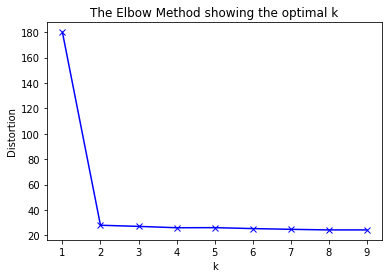

In [39]:
from scipy.spatial.distance import cdist

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(london_grouped_clustering)
    
    distortions.append(sum(np.min(cdist(london_grouped_clustering, kmeanModel.cluster_centers_, 'canberra'), axis=1)) / london_grouped_clustering.shape[0])

#There are different metric distance function for spatial distance. 
#I choose correlation instaed of euclidean because the canberra function gives me more clear view of elbow break point.

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [40]:
london_merged = london_data

# add clustering labels
london_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
london_merged = london_merged.join(boroughs_venues_sorted.set_index('Borough'), on='Name')

london_merged.head() # check the last columns!

,Name,Ratio,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,City of London,17.51,51.507322,-0.127647,2,Theater,Hotel,Japanese Restaurant,Plaza,Art Gallery,Cocktail Bar,Steakhouse,Sandwich Place,Garden,Ramen Restaurant
1,Barking and Dagenham,10.55,51.554117,0.150504,1,Bus Stop,Convenience Store,Liquor Store,Grocery Store,Filipino Restaurant,Fountain,Food Truck,Food & Drink Shop,Food,Flea Market
2,Barnet,15.19,51.653090,-0.200226,1,Coffee Shop,Park,Pharmacy,Convenience Store,Pub,Restaurant,Bookstore,Grocery Store,Italian Restaurant,Sandwich Place
3,Bexley,10.40,51.441679,0.150488,0,Pub,Fast Food Restaurant,Indian Restaurant,Greek Restaurant,Breakfast Spot,Italian Restaurant,Train Station,Toy / Game Store,Chinese Restaurant,Food & Drink Shop
4,Brent,15.93,51.441635,0.234519,1,Pizza Place,Pub,Garden Center,Park,Farmers Market,Food & Drink Shop,Food,Flea Market,Fish Market,Fish & Chips Shop


**We can also estimate the number of 1st Most Common Venue in each cluster.Thus, we can create a bar chart which may help us to find proper label names for each cluster.**

In [41]:
count_venue = london_merged
count_venue = count_venue.groupby(['Cluster Labels','1st Most Common Venue']).size().reset_index(name='Counts')

#we can transpose it to plot bar chart
cv_cluster = count_venue.pivot(index='Cluster Labels', columns='1st Most Common Venue', values='Counts')
cv_cluster = cv_cluster.fillna(0).astype(int).reset_index(drop=True)
cv_cluster

1st Most Common Venue,Bakery,Bus Stop,Café,Clothing Store,Coffee Shop,Hotel,Pizza Place,Pub,Theater,Tram Station
0,0,0,0,0,0,0,0,1,0,0
1,1,2,2,3,3,1,2,3,0,1
2,0,0,0,0,0,0,0,0,1,0


Text(0, 0.5, 'Clusters')

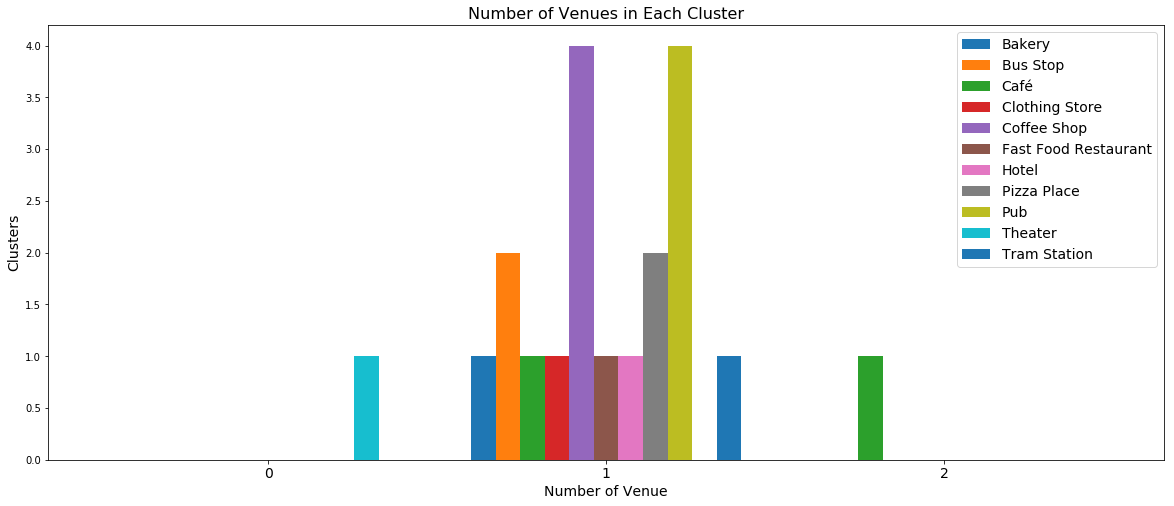

In [80]:
#creating a bar chart of "Number of Venues in Each Cluster"
frame=cv_cluster.plot(kind='bar',figsize=(20,8),width = 0.8)

plt.legend(labels=cv_cluster.columns,fontsize= 14)
plt.title("Number of Venues in Each Cluster",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Number of Venue', fontsize=14)
plt.ylabel('Clusters', fontsize=14)

In [42]:
Cluster_labels = {'Clusters': [0,1,2], 'Labels': ["Cafe Venues","Multiple Social Venues","Accommodation & Intensive Cafe Venues"]}
Cluster_labels = pd.DataFrame(data=Cluster_labels)
Cluster_labels

,Clusters,Labels
0,0,Cafe Venues
1,1,Multiple Social Venues
2,2,Accommodation & Intensive Cafe Venues


Let's analyze the housing sales prices for per square meter in specific range. Thus we can create new labels which involve pricing features, as well.

In [43]:
data_process = df_uk.drop(['Latitude', 'Longitude'], axis=1)
data_process.head()

,Name,Ratio,Cluster Labels
0,City of London,17.51,2
1,Barking and Dagenham,10.55,1
2,Barnet,15.19,1
3,Bexley,10.40,0
4,Brent,15.93,1


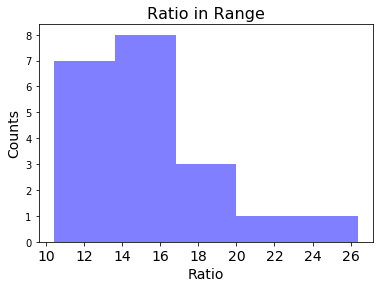

In [44]:
num_bins = 5
n, bins, patches = plt.hist(data_process['Ratio'], num_bins, facecolor='blue', alpha=0.5)
plt.title("Ratio in Range",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Ratio', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.show()

In this case, we can create "Level_labels" with those levels.

In [45]:

level = []
for i in range(0,len(data_process)):
    if (data_process['Ratio'][i] < 5):
        level.append("Low Level of Price")
    elif (data_process['Ratio'][i] >= 5 and data_process['Ratio'][i] < 8):
        level.append("Mid-1 Level of Price")
    elif (data_process['Ratio'][i] >= 8 and data_process['Ratio'][i] < 10):
        level.append("Mid-2 Level of Price")
    elif (data_process['Ratio'][i] >= 10 and data_process['Ratio'][i] < 12):
        level.append("High-1 Level of Price")
    else:
        level.append("High-2 Level of Price")   

data_process['Level_labels'] = level
data_process.head()

,Name,Ratio,Cluster Labels,Level_labels
0,City of London,17.51,2,High-2 Level of Price
1,Barking and Dagenham,10.55,1,High-1 Level of Price
2,Barnet,15.19,1,High-2 Level of Price
3,Bexley,10.40,0,High-1 Level of Price
4,Brent,15.93,1,High-2 Level of Price


In [46]:

top3 = london_venues.groupby(['Borough','Venue Category']).size().reset_index(name='Counts')
top3 = top3.sort_values(['Borough','Counts'],ascending=False).groupby('Borough').head(3).reset_index(drop=True)

top3['Join'] = top3['Counts'].map(str) + " " + top3['Venue Category']
top3 = top3.groupby(['Borough'])['Join'].apply(", ".join).reset_index()

top3.head()

,Borough,Join
0,Barking and Dagenham,"2 Bus Stop, 1 Convenience Store, 1 Grocery Store"
1,Barnet,"4 Coffee Shop, 3 Park, 2 Bookstore"
2,Bexley,"2 Fast Food Restaurant, 2 Pub, 1 Breakfast Spot"
3,Brent,"1 Garden Center, 1 Park, 1 Pizza Place"
4,Camden,"9 Pub, 7 Coffee Shop, 5 Burger Joint"


## C. Results

### C.1 Main table with results
Let's merge those new variables with related cluster informations in our main London_merged table

In [47]:

import numpy as np

result = pd.merge(london_merged, 
                    top3[['Borough', 'Join']],
                    left_on = 'Name',
                    right_on = 'Borough',
                    how = 'left')
result= pd.merge(result, 
                    Cluster_labels[['Clusters', 'Labels']],
                    left_on = 'Cluster Labels',
                    right_on = 'Clusters',
                    how = 'left')
result = pd.merge(result, 
                    data_process[['Name']],
                    left_on = 'Name',
                    right_on = 'Name',
                    how = 'left')
result = pd.merge(result, 
                    data_process[['Name', 'Level_labels']],
                    left_on = 'Name',
                    right_on = 'Name',
                    how = 'left')

result = result.drop(['Clusters'], axis=1)
result.head(3)



,Name,Ratio,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Borough,Join,Labels,Level_labels
0,City of London,17.51,51.507322,-0.127647,2,Theater,Hotel,Japanese Restaurant,Plaza,Art Gallery,Cocktail Bar,Steakhouse,Sandwich Place,Garden,Ramen Restaurant,City of London,"6 Theater, 5 Hotel, 4 Japanese Restaurant",Accommodation & Intensive Cafe Venues,High-2 Level of Price
1,Barking and Dagenham,10.55,51.554117,0.150504,1,Bus Stop,Convenience Store,Liquor Store,Grocery Store,Filipino Restaurant,Fountain,Food Truck,Food & Drink Shop,Food,Flea Market,Barking and Dagenham,"2 Bus Stop, 1 Convenience Store, 1 Grocery Store",Multiple Social Venues,High-1 Level of Price
2,Barnet,15.19,51.653090,-0.200226,1,Coffee Shop,Park,Pharmacy,Convenience Store,Pub,Restaurant,Bookstore,Grocery Store,Italian Restaurant,Sandwich Place,Barnet,"4 Coffee Shop, 3 Park, 2 Bookstore",Multiple Social Venues,High-2 Level of Price


### C.2. Map of Cluster Results

In [48]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, join, cluster_number, label in zip(result['Latitude'], result['Longitude'], result['Borough'], result['Labels'], result['Join'], result['Cluster Labels'], result['Level_labels']):
    label = folium.Popup(str(poi) + " / " + str(cluster) + "-" + str(label) + " / " + str(join), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        color= rainbow[cluster_number-1],
        popup=label,
        fill_color = rainbow[cluster_number-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

In [50]:
!wget --quiet https://github.com/Elnazlmch/github-example/blob/master/uk_data.csv -O london_geo.json
    
#https://geo.nyu.edu/download/file/stanford-nj696zj1674-geojson.json    
print('GeoJSON file downloaded!')

london_geo = r'london_geo.json'


latitude = 51.5074
longitude = 0.1278

# display San-Francisco
london_map = folium.Map(location=[latitude, longitude], zoom_start=10)

GeoJSON file downloaded!


In [ ]:
london_map.choropleth(
    geo_data=london_geo,
    data=london_data,
    columns=['Name','Ratio'],
    key_on='feature.properties.name_2',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Price',
    highlight=True
)
markers_colors = []
for lat, lon, poi, cluster, join, cluster_number, label in zip(result['Latitude'], result['Longitude'], result['Borough'], result['Labels'], result['Join'], result['Cluster Labels'], results['Label']):
    label = folium.Popup(str(poi) + " / " + str(cluster) + "-" + str(label) + " / " + str(join), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color= rainbow[cluster_number-1],
        fill=True,
        fill_color= rainbow[cluster_number-1],
        fill_opacity=1).add_to(london_map)
   


#display map
london_map

## D. Discussion

As mentioned earlier, London is a big city with a high population density. The total number of measurements and population densities of the 20 (in this work) districts in total can vary. As there is such a complexity, very different approaches can be tried in clustering and classification studies. Moreover, it is obvious that not every classification method can yield the same high quality results for this metropole.
Using Kmeans algorithm as part of this clustering study. Based on the Elbow method, the optimum k value is set to 2. However, only 20 district coordinates were used. 
Also, data analysis was done through this information by adding the coordinates of districts and affordability as static data on GitHub. 
This work finalized by visualizing the data and clustering information on the London map. 
As a result, people can achieve better outcomes through their access to the platforms where such information is provided in order to make a decision regarding business start/development.
Not only for investors but also city managers can manage the city more regularly by using similar data analysis types or platforms.

